In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [2]:
# Load data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRC4x6mecC7EkofiP3uJWZ3Y1jD1B2QMZXjlFtdP9-TOan6Fms2TqyOyssHegjTeG7iM6f-qX89vfvK/pub?gid=0&single=true&output=csv"
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y')
df.set_index('Date', inplace=True)
df['Biomass']=df['Biomass'].dropna()

In [3]:
# Load and preprocess data
# Assuming df is already loaded with 'Biomass' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Biomass'].values.reshape(-1,1))

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5  # Number of previous time steps to consider
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape input to be [samples, time steps, features]


In [4]:
# Create LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [5]:
# Train the model
model.fit(X, y, epochs=100, batch_size=32)


Epoch 1/100
3/3 [==============================] - 3s 8ms/step - loss: 0.2200
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1364
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0708
Epoch 4/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0348
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0498
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0544
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0404
Epoch 8/100
3/3 [==============================] - 0s 7ms/step - loss: 0.0342
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0379
Epoch 10/100
3/3 [==============================] - 0s 7ms/step - loss: 0.0402
Epoch 11/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0388
Epoch 12/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0356
Epoch 13/100
3/3 [==============================] - 0s 8ms/s

In [6]:
# Making predictions
train_predictions = model.predict(X)

# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
y_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Calculate error metrics
train_mse = mean_squared_error(y_actual, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_actual, train_predictions)
train_r2 = r2_score(y_actual, train_predictions)

print(f"Training Metrics:\nMSE: {train_mse}, RMSE: {train_rmse}, MAE: {train_mae}, R-squared: {train_r2}")


3/3 [==============================] - 1s 4ms/step
Training Metrics:
MSE: 1169.8915751401712, RMSE: 34.203677801373516, MAE: 26.971698584923377, R-squared: 0.5312709827652184


In [8]:
# Forecast future values
future_months = 30
future_predictions = []
current_batch = scaled_data[-look_back:]

for i in range(future_months):
    current_pred = model.predict(current_batch.reshape(1, look_back, 1))
    future_predictions.append(current_pred[0, 0])
    current_batch = np.append(current_batch[1:], current_pred)

# Inverse transform the predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = pd.date_range(start=df.index[-1], periods=future_months + 1, freq='M')[1:]
future_series = pd.Series(future_predictions.flatten(), index=future_dates)


1/1 [==============================] - 0s 16ms/step


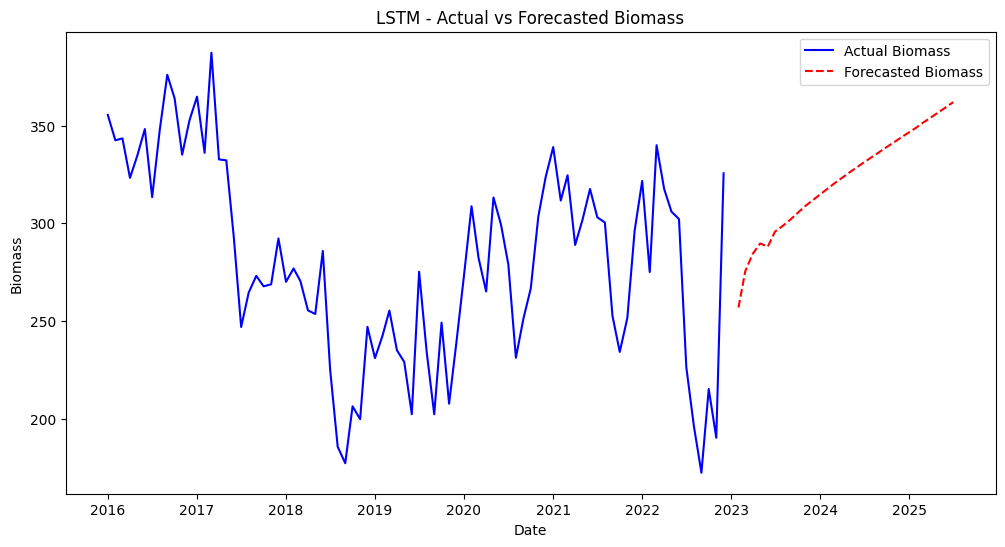

In [10]:
# Plotting the original and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Biomass'], label='Actual Biomass', color='blue')
plt.plot(future_series.index, future_series, label='Forecasted Biomass', color='red', linestyle='dashed')
plt.title('LSTM - Actual vs Forecasted Biomass')
plt.xlabel('Date')
plt.ylabel('Biomass')
plt.legend()
plt.show()

